# Project:  Holiday weather

by Aya Tamura, 1 November 2023

I love Edingburgh! I would love to visit there for my summer break, however, when should I plan my holiday?

In this project, I am going to use the 10 years historic weather data from Open Meteo for the city of Edinburgh to try to predict two good weather weeks to take off as holiday next summer. 

Of course the weather in the next summer of 2024 may be very different in the past, but it should give me some indication of when would be a good time to take a summer break.

## Getting the data

*[Open Meteo](https://open-meteo.com/en/docs/historical-weather-api)* keeps historical weather data collected in the world. I downloaded the weather related data from 2013 to 2023 in the city of Edinburgh for free of charge.



In [1282]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
from datetime import datetime
import math

# Load data as dataframe
df = pd.read_csv('Edinburgh_2013_2023_rev.csv', skipinitialspace=True, low_memory=False)
df.head(5)

,Edinburgh_2013_2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
1,2013-01-01T00:00,2.7,85,0.5,-2.6,0.00,0.00,0.00,0.00,22.4,37.0,240,242,46.4
2,2013-01-01T01:00,2.7,86,0.5,-2.6,0.00,0.00,0.00,0.00,22.6,36.6,239,241,46.8
3,2013-01-01T02:00,2.6,86,0.5,-2.7,0.00,0.00,0.00,0.00,22.6,36.9,239,241,45.7
4,2013-01-01T03:00,2.6,85,0.4,-2.8,0.00,0.00,0.00,0.00,22.8,37.5,239,242,46.4


## Cleaning the data
First we need to clean up the data. It appears that the columns names are not set and need to be set with the first row.

In [1283]:
# Set columns name with the first row and drop it
df.columns = df.iloc[0]
df = df.drop(index=0)
df.head()

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
1,2013-01-01T00:00,2.7,85,0.5,-2.6,0.00,0.00,0.00,0.00,22.4,37.0,240,242,46.4
2,2013-01-01T01:00,2.7,86,0.5,-2.6,0.00,0.00,0.00,0.00,22.6,36.6,239,241,46.8
3,2013-01-01T02:00,2.6,86,0.5,-2.7,0.00,0.00,0.00,0.00,22.6,36.9,239,241,45.7
4,2013-01-01T03:00,2.6,85,0.4,-2.8,0.00,0.00,0.00,0.00,22.8,37.5,239,242,46.4
5,2013-01-01T04:00,2.6,84,0.2,-2.8,0.00,0.00,0.00,0.00,23.0,38.2,241,244,46.1


Next, let's check the data types.

In [1284]:
df.dtypes

0
time                         object
temperature_2m (°C)          object
relativehumidity_2m (%)      object
dewpoint_2m (°C)             object
apparent_temperature (°C)    object
precipitation (mm)           object
rain (mm)                    object
snowfall (cm)                object
snow_depth (m)               object
windspeed_10m (km/h)         object
windspeed_100m (km/h)        object
winddirection_10m (°)        object
winddirection_100m (°)       object
windgusts_10m (km/h)         object
dtype: object

Strangely, all columns are stored as object. We need to change the data types.
Let's start from 'time' which is date.

In [1285]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
print(df.dtypes)

0
time                         datetime64[ns]
temperature_2m (°C)                  object
relativehumidity_2m (%)              object
dewpoint_2m (°C)                     object
apparent_temperature (°C)            object
precipitation (mm)                   object
rain (mm)                            object
snowfall (cm)                        object
snow_depth (m)                       object
windspeed_10m (km/h)                 object
windspeed_100m (km/h)                object
winddirection_10m (°)                object
winddirection_100m (°)               object
windgusts_10m (km/h)                 object
dtype: object


Well 'time' is converted as date successfully. The rest columns are supposed to be numeric data. Let's explore dataset to understand why they are stored as object.

In [1286]:
obj_col = df.select_dtypes(include = 'object').columns
df[obj_col]

,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
1,2.7,85,0.5,-2.6,0.00,0.00,0.00,0.00,22.4,37.0,240,242,46.4
2,2.7,86,0.5,-2.6,0.00,0.00,0.00,0.00,22.6,36.6,239,241,46.8
3,2.6,86,0.5,-2.7,0.00,0.00,0.00,0.00,22.6,36.9,239,241,45.7
4,2.6,85,0.4,-2.8,0.00,0.00,0.00,0.00,22.8,37.5,239,242,46.4
5,2.6,84,0.2,-2.8,0.00,0.00,0.00,0.00,23.0,38.2,241,244,46.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98898,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98899,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98900,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98901,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


There are many missing values. That's why it was sotred as object.

In [1287]:
display(df)


,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
1,2013-01-01 00:00:00,2.7,85,0.5,-2.6,0.00,0.00,0.00,0.00,22.4,37.0,240,242,46.4
2,2013-01-01 01:00:00,2.7,86,0.5,-2.6,0.00,0.00,0.00,0.00,22.6,36.6,239,241,46.8
3,2013-01-01 02:00:00,2.6,86,0.5,-2.7,0.00,0.00,0.00,0.00,22.6,36.9,239,241,45.7
4,2013-01-01 03:00:00,2.6,85,0.4,-2.8,0.00,0.00,0.00,0.00,22.8,37.5,239,242,46.4
5,2013-01-01 04:00:00,2.6,84,0.2,-2.8,0.00,0.00,0.00,0.00,23.0,38.2,241,244,46.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98898,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98899,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98900,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98901,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [1288]:
# Drop missing values in 'time'
df = df.dropna(subset=['time'])

In [1289]:
df.tail(5)

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
94940,2023-10-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94941,2023-10-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94942,2023-10-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94943,2023-10-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94944,2023-10-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are still missing values in `'temperature'`.

In [1290]:
# Drop missing values in 'temperature'
df = df.dropna(subset=['temperature_2m (°C)'])
df.tail()

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
94820,2023-10-26 19:00:00,10.1,94,9.1,6.9,0.60,0.60,0.00,0.00,20.0,32.4,113,116,38.2
94821,2023-10-26 20:00:00,10.3,93,9.2,6.9,0.40,0.40,0.00,0.00,21.9,34.3,113,115,42.8
94822,2023-10-26 21:00:00,10.4,90,8.9,6.8,0.40,0.40,0.00,0.00,22.8,35.4,108,111,47.2
94823,2023-10-26 22:00:00,10.4,90,8.8,7.0,0.60,0.60,0.00,0.00,21.7,35.7,102,105,48.6
94824,2023-10-26 23:00:00,10.3,91,8.9,6.8,0.60,0.60,0.00,0.00,21.7,35.0,102,105,50.0


In [1291]:
# Convert the data types into float
df['temperature_2m (°C)'] = df['temperature_2m (°C)'].astype(float)
df.dtypes

0
time                         datetime64[ns]
temperature_2m (°C)                 float64
relativehumidity_2m (%)              object
dewpoint_2m (°C)                     object
apparent_temperature (°C)            object
precipitation (mm)                   object
rain (mm)                            object
snowfall (cm)                        object
snow_depth (m)                       object
windspeed_10m (km/h)                 object
windspeed_100m (km/h)                object
winddirection_10m (°)                object
winddirection_100m (°)               object
windgusts_10m (km/h)                 object
dtype: object

In [1292]:
df[obj_col] = df[obj_col].astype(float)
df.dtypes

0
time                         datetime64[ns]
temperature_2m (°C)                 float64
relativehumidity_2m (%)             float64
dewpoint_2m (°C)                    float64
apparent_temperature (°C)           float64
precipitation (mm)                  float64
rain (mm)                           float64
snowfall (cm)                       float64
snow_depth (m)                      float64
windspeed_10m (km/h)                float64
windspeed_100m (km/h)               float64
winddirection_10m (°)               float64
winddirection_100m (°)              float64
windgusts_10m (km/h)                float64
dtype: object

In [1293]:
display(df)

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
1,2013-01-01 00:00:00,2.7,85.0,0.5,-2.6,0.0,0.0,0.0,0.0,22.4,37.0,240.0,242.0,46.4
2,2013-01-01 01:00:00,2.7,86.0,0.5,-2.6,0.0,0.0,0.0,0.0,22.6,36.6,239.0,241.0,46.8
3,2013-01-01 02:00:00,2.6,86.0,0.5,-2.7,0.0,0.0,0.0,0.0,22.6,36.9,239.0,241.0,45.7
4,2013-01-01 03:00:00,2.6,85.0,0.4,-2.8,0.0,0.0,0.0,0.0,22.8,37.5,239.0,242.0,46.4
5,2013-01-01 04:00:00,2.6,84.0,0.2,-2.8,0.0,0.0,0.0,0.0,23.0,38.2,241.0,244.0,46.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94820,2023-10-26 19:00:00,10.1,94.0,9.1,6.9,0.6,0.6,0.0,0.0,20.0,32.4,113.0,116.0,38.2
94821,2023-10-26 20:00:00,10.3,93.0,9.2,6.9,0.4,0.4,0.0,0.0,21.9,34.3,113.0,115.0,42.8
94822,2023-10-26 21:00:00,10.4,90.0,8.9,6.8,0.4,0.4,0.0,0.0,22.8,35.4,108.0,111.0,47.2
94823,2023-10-26 22:00:00,10.4,90.0,8.8,7.0,0.6,0.6,0.0,0.0,21.7,35.7,102.0,105.0,48.6


We also need to change the index from the default to the `datetime64` values in the `'time'` column so that it is easier to pull out rows between particular dates and display more meaningful graphs: 

In [1294]:
df.index = df['time']

## Finding a summer break

According to meteorologists, summer extends for the whole months of June, July, and August in the northern hemisphere and the whole months of December, January, and February in the southern hemisphere. So as I'm in the northern hemisphere I'm going to create a dataframe that holds just those months using the `datetime` index, like this:

In [1295]:
# Filter data for the summer months
summer = df[(df['time'].dt.month >= 6) & (df['time'].dt.month <= 8)]

I now look for the days with warm temperatures. I would like to set higher than 20 degrees.

In [1296]:
summer = summer[summer['temperature_2m (°C)'] >= 20]
summer

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h)
time,,,,,,,,,,,,,,
2013-07-06 13:00:00,2013-07-06 13:00:00,20.2,55.0,10.8,18.8,0.0,0.0,0.0,0.0,20.9,28.6,228.0,228.0,46.8
2013-07-06 14:00:00,2013-07-06 14:00:00,20.5,53.0,10.7,19.0,0.0,0.0,0.0,0.0,20.7,28.1,229.0,229.0,45.7
2013-07-06 15:00:00,2013-07-06 15:00:00,20.6,53.0,10.7,18.8,0.0,0.0,0.0,0.0,20.4,28.2,234.0,235.0,45.4
2013-07-06 16:00:00,2013-07-06 16:00:00,20.3,55.0,10.8,17.9,0.0,0.0,0.0,0.0,20.5,28.4,239.0,240.0,45.0
2013-07-07 12:00:00,2013-07-07 12:00:00,20.2,58.0,11.8,21.1,0.0,0.0,0.0,0.0,7.6,9.5,262.0,261.0,25.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 16:00:00,2023-08-10 16:00:00,21.5,81.0,18.0,23.0,0.0,0.0,0.0,0.0,9.9,15.2,136.0,144.0,23.4
2023-08-10 17:00:00,2023-08-10 17:00:00,21.6,81.0,18.2,23.3,0.0,0.0,0.0,0.0,8.9,13.7,148.0,157.0,22.7
2023-08-10 18:00:00,2023-08-10 18:00:00,21.3,83.0,18.3,23.3,0.0,0.0,0.0,0.0,7.1,11.8,131.0,153.0,19.1


# Visualise data
Best to see a graph of the temperature and look for the warmest period.

In [1297]:
%matplotlib inline

Now let's plot the `'temperature_2m'`, `'precipitation (mm)'`, and `'relativehumidity_2m (%)'` for the summer:

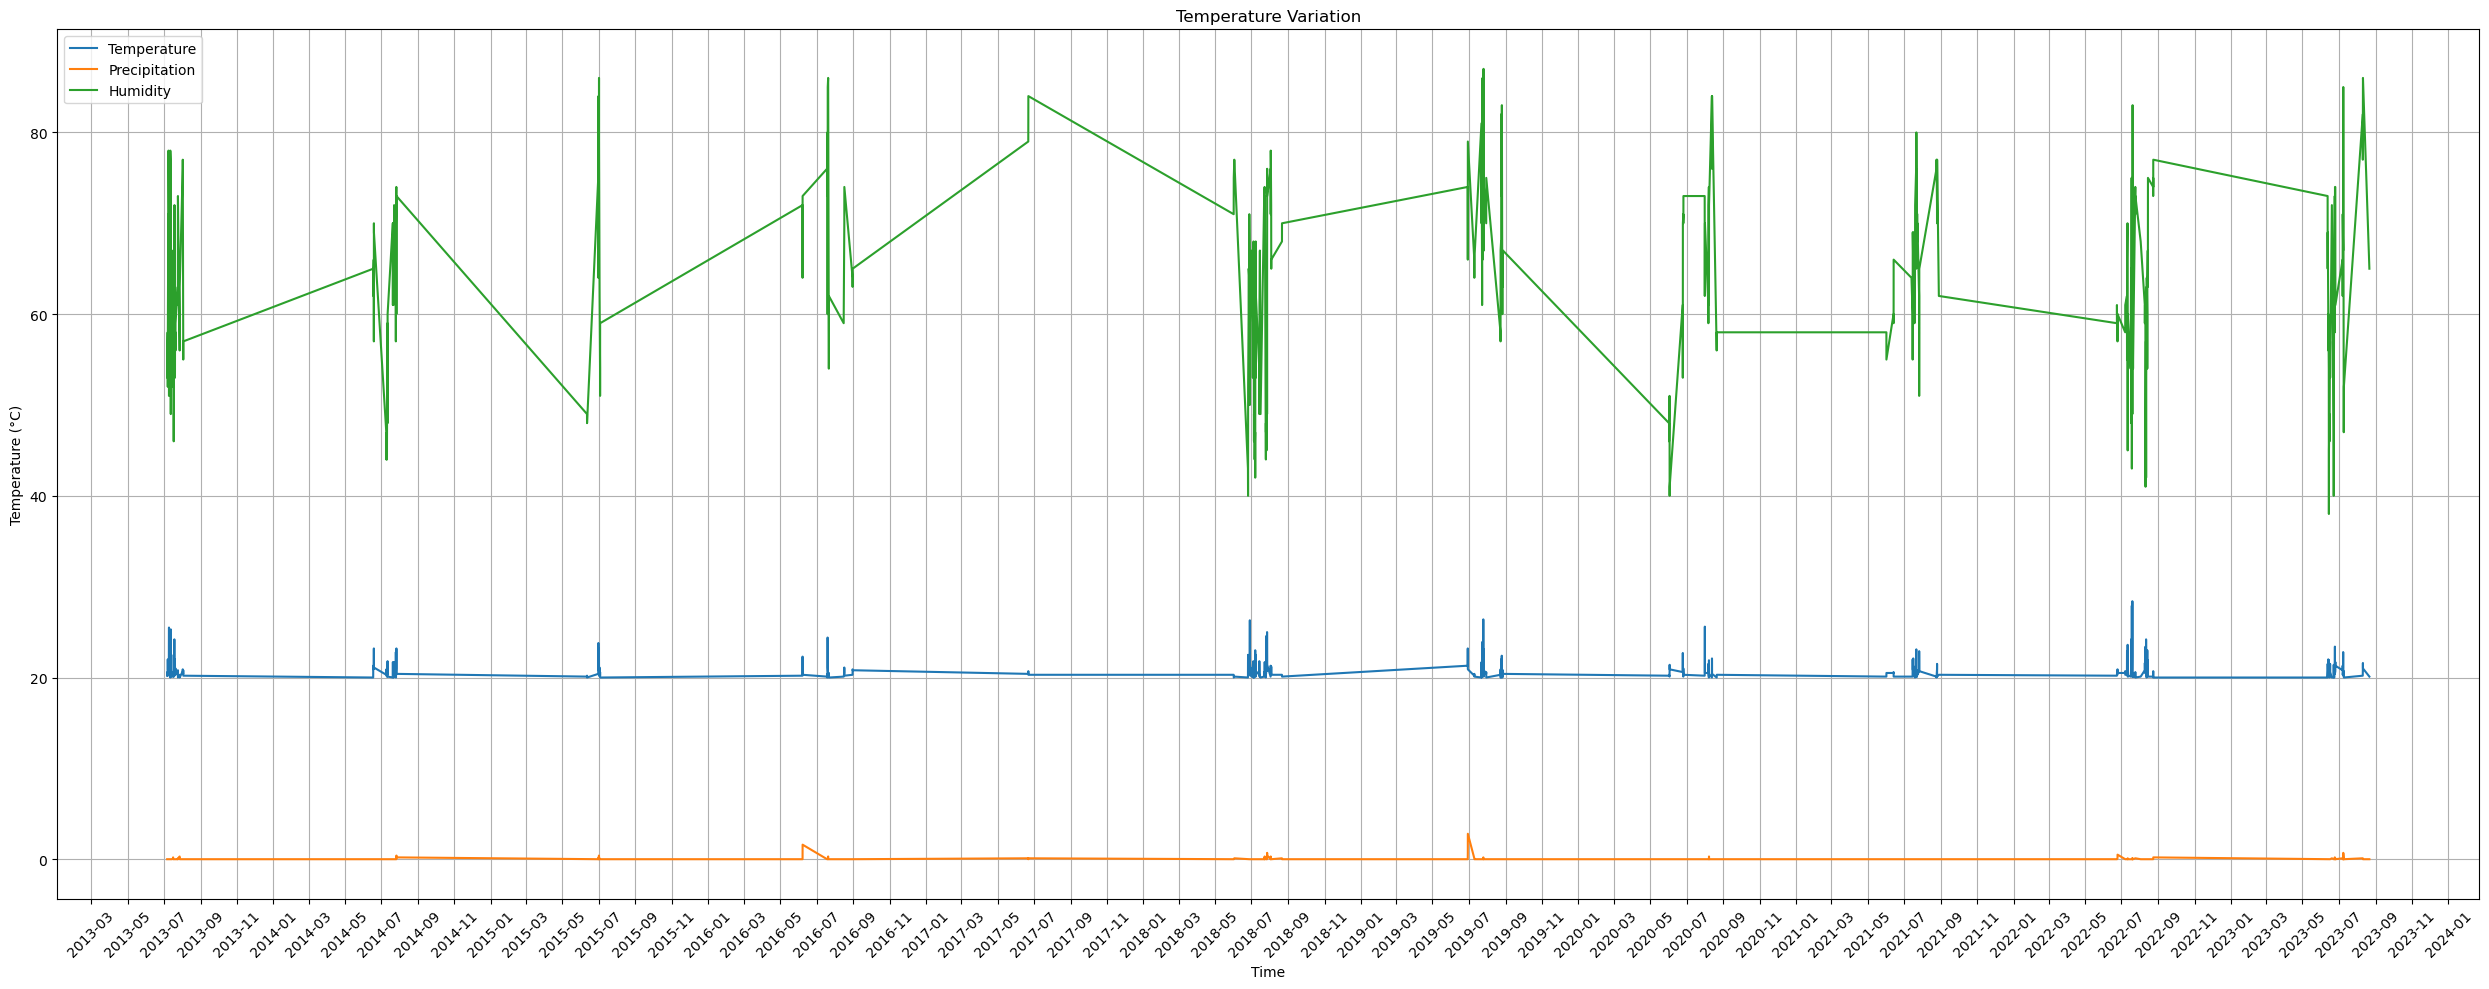

In [1333]:
# Plot the desired column
plt.figure(figsize=(25, 10))
plt.plot(summer['time'], summer['temperature_2m (°C)'], label='Temperature')
plt.plot(summer['time'], summer['precipitation (mm)'], label='Precipitation')
plt.plot(summer['time'], summer['relativehumidity_2m (%)'], label='Humidity')
plt.grid(True)

# Customize the x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Display ticks every 2 months
plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.legend()
plt.show()

It is not easy to read. Let's see year by year.

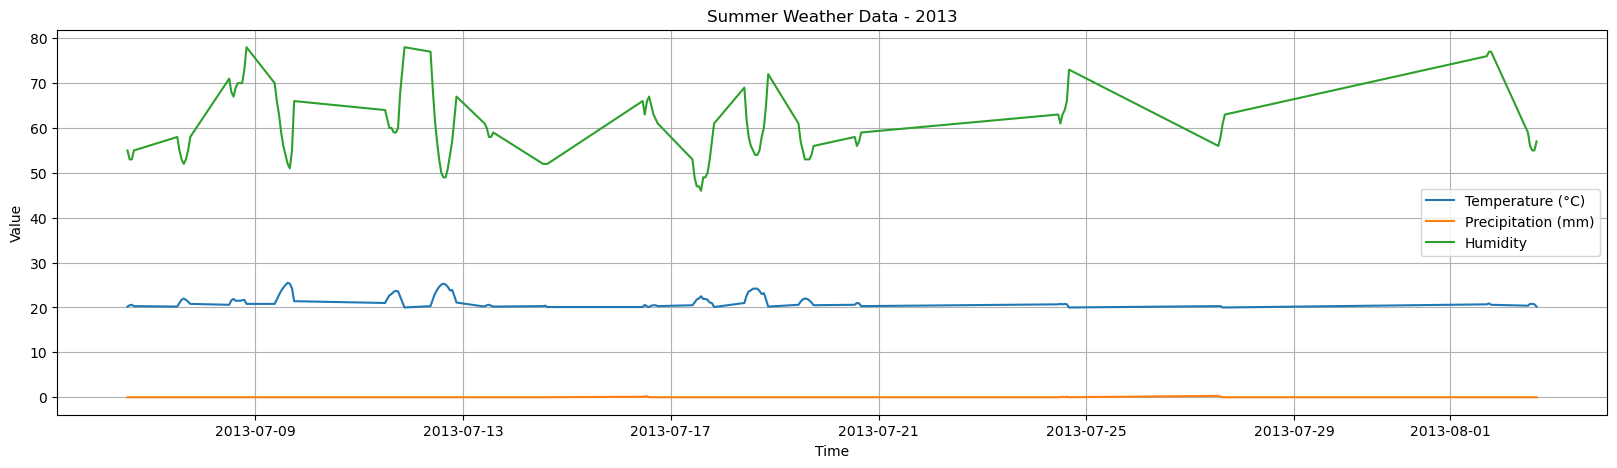

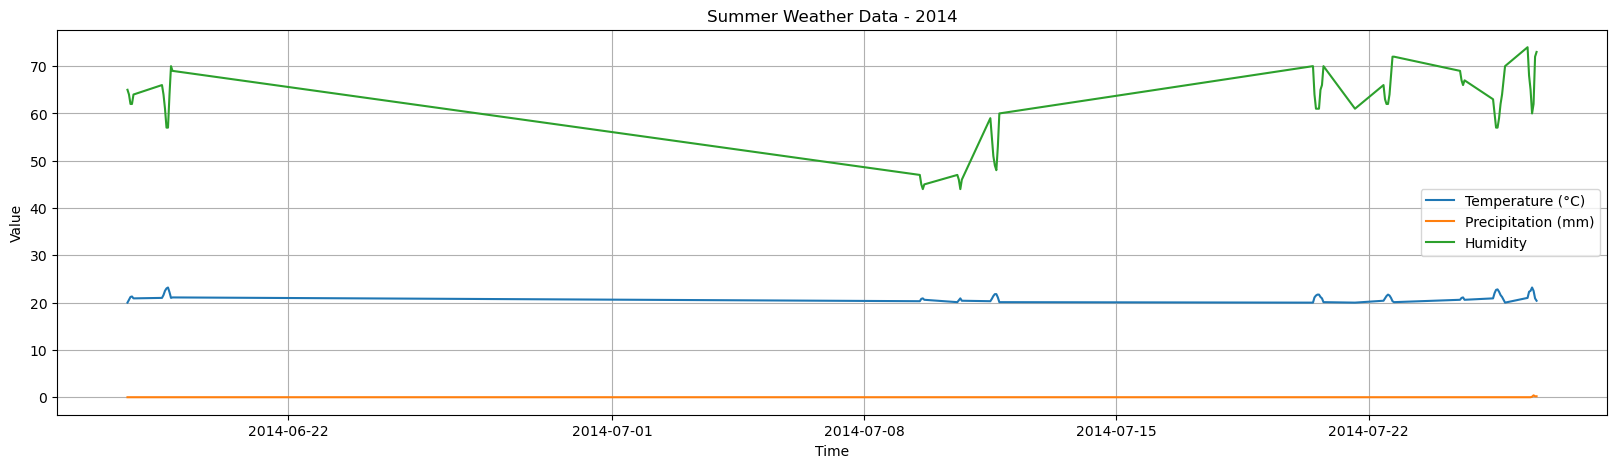

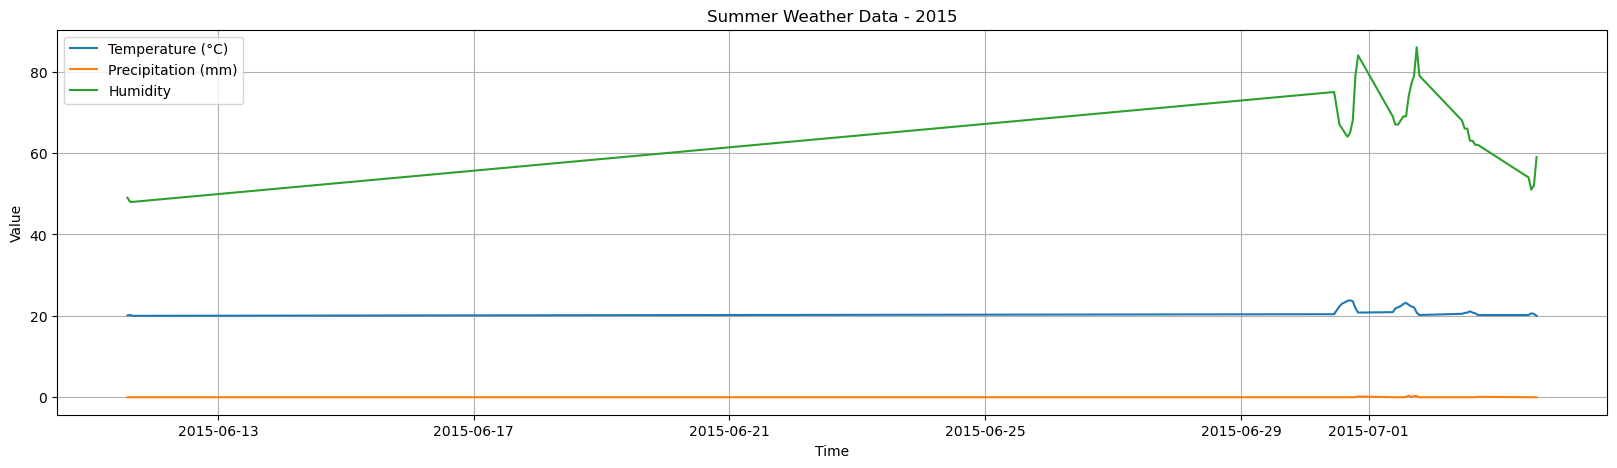

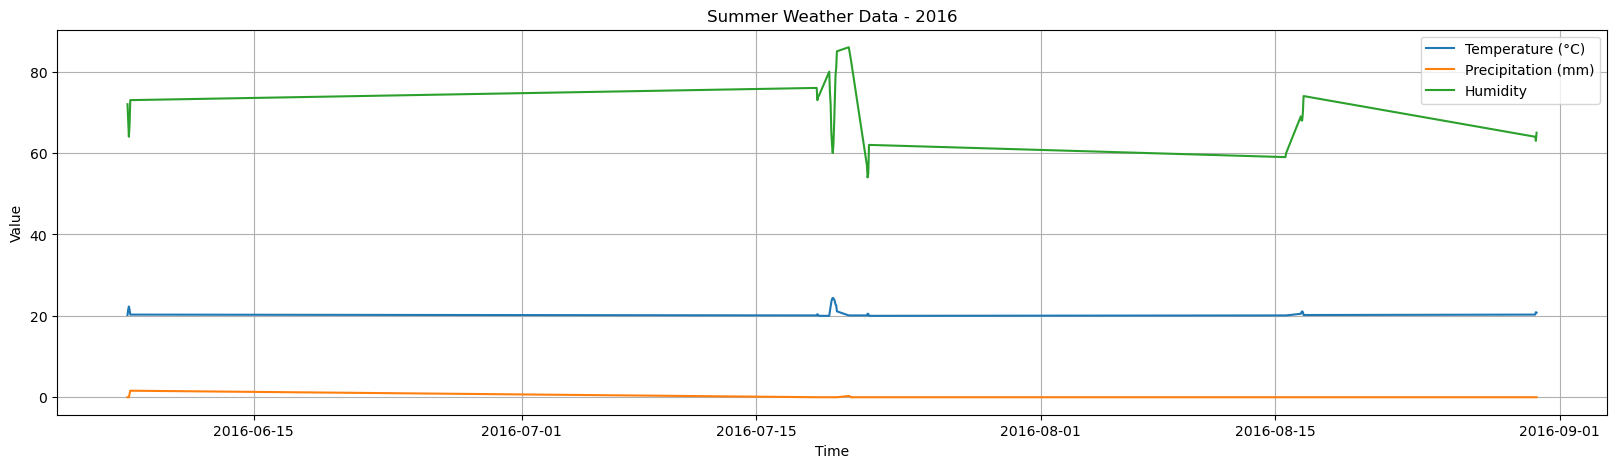

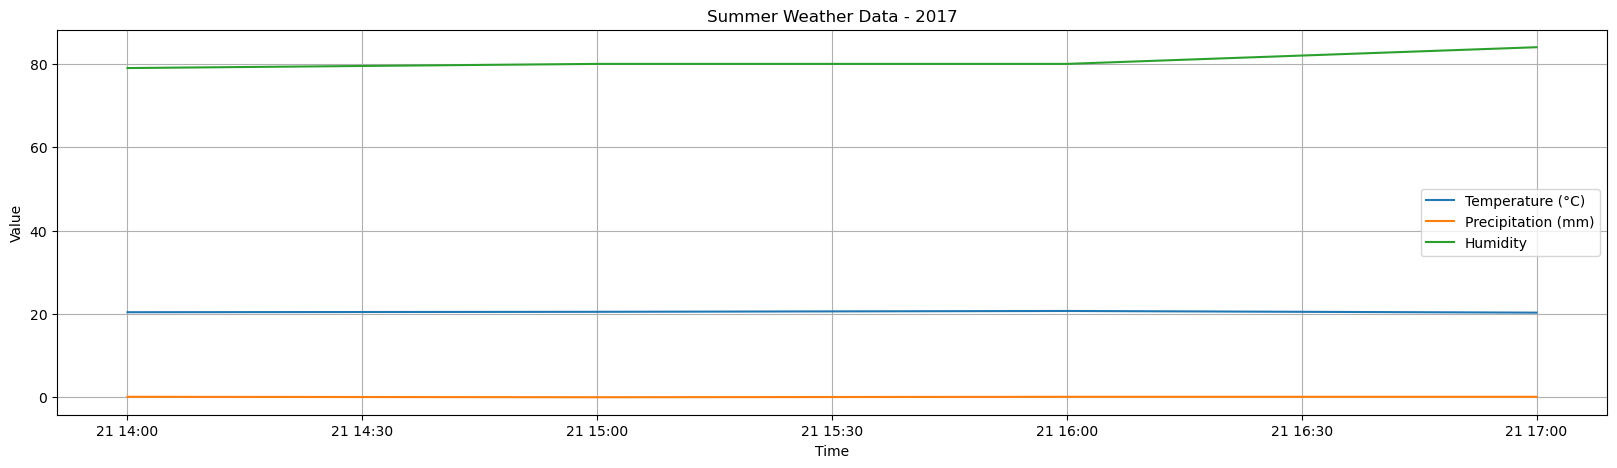

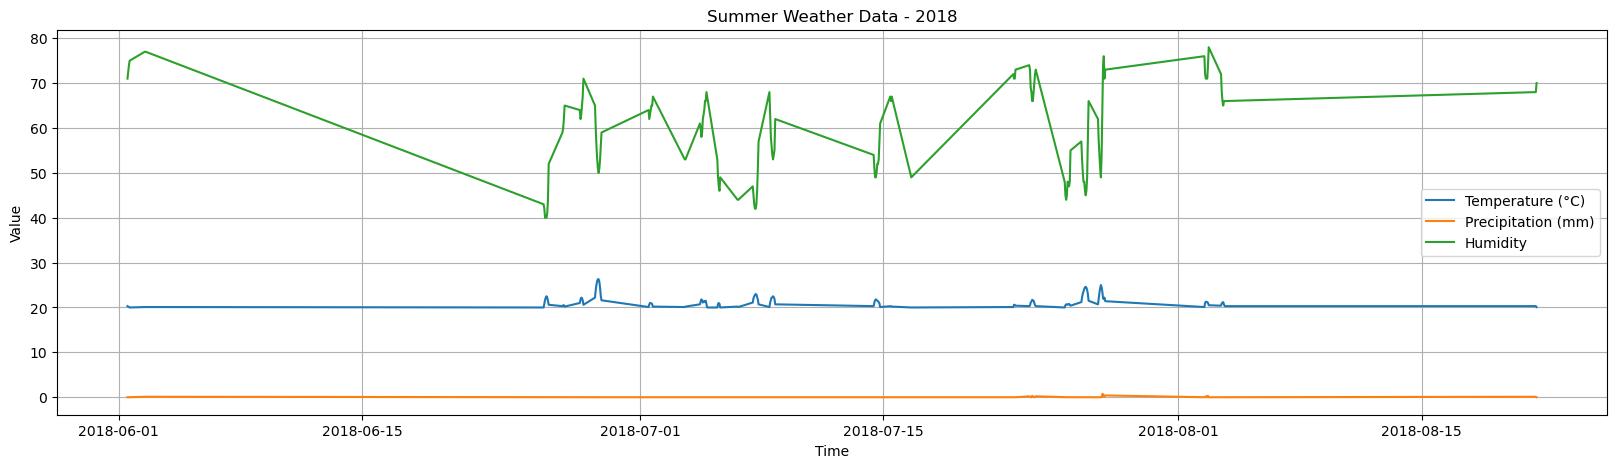

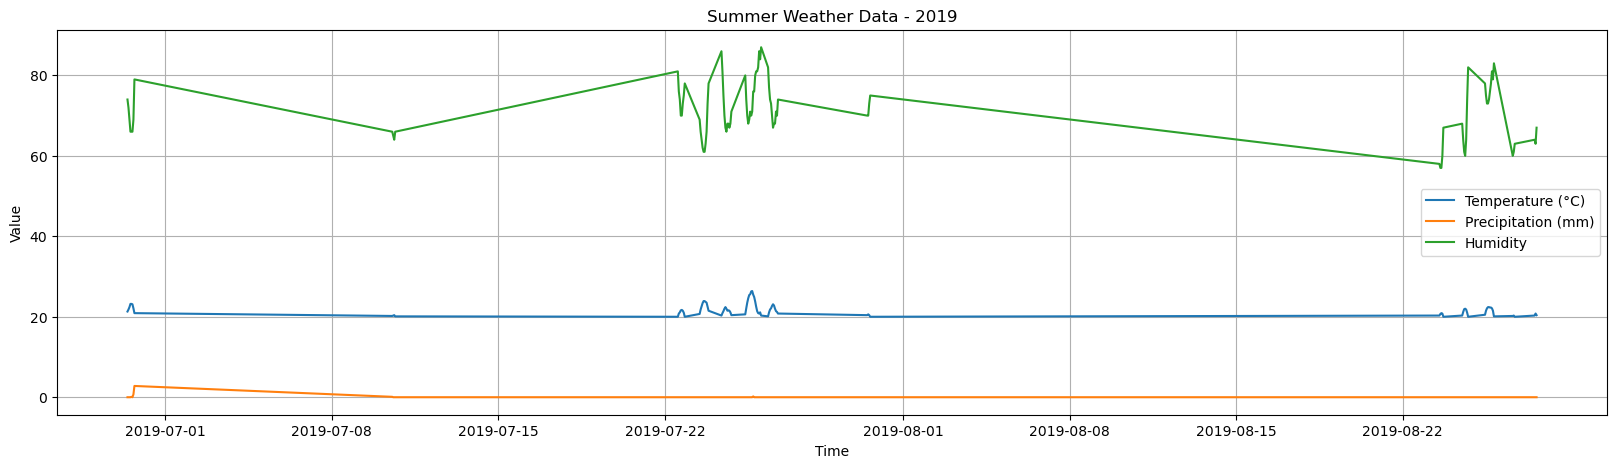

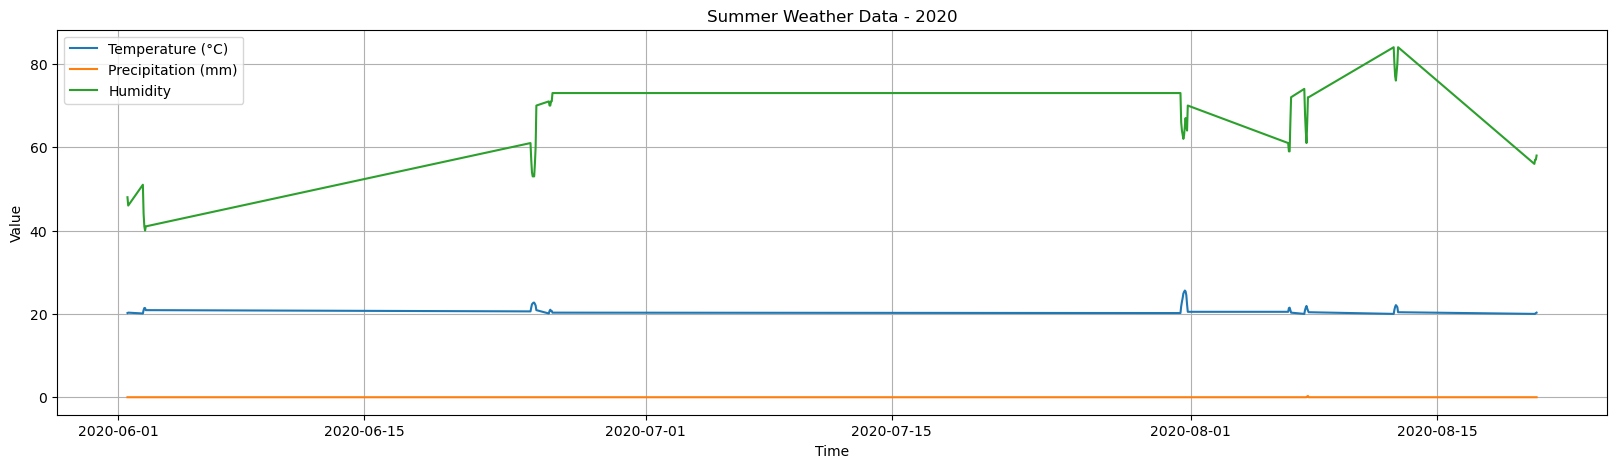

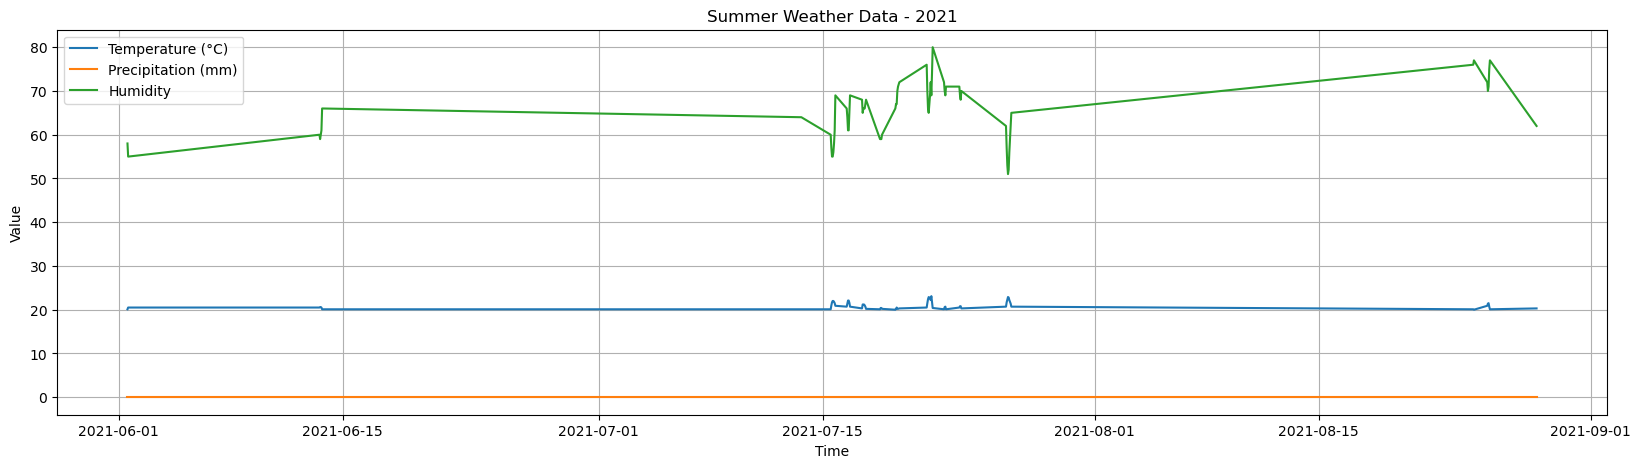

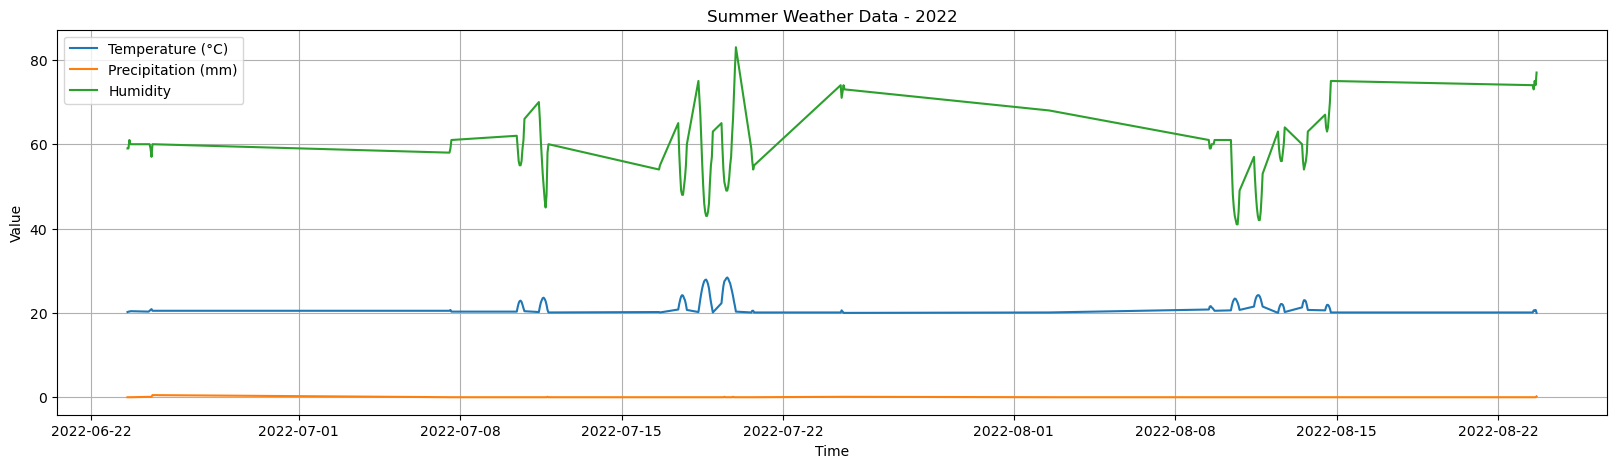

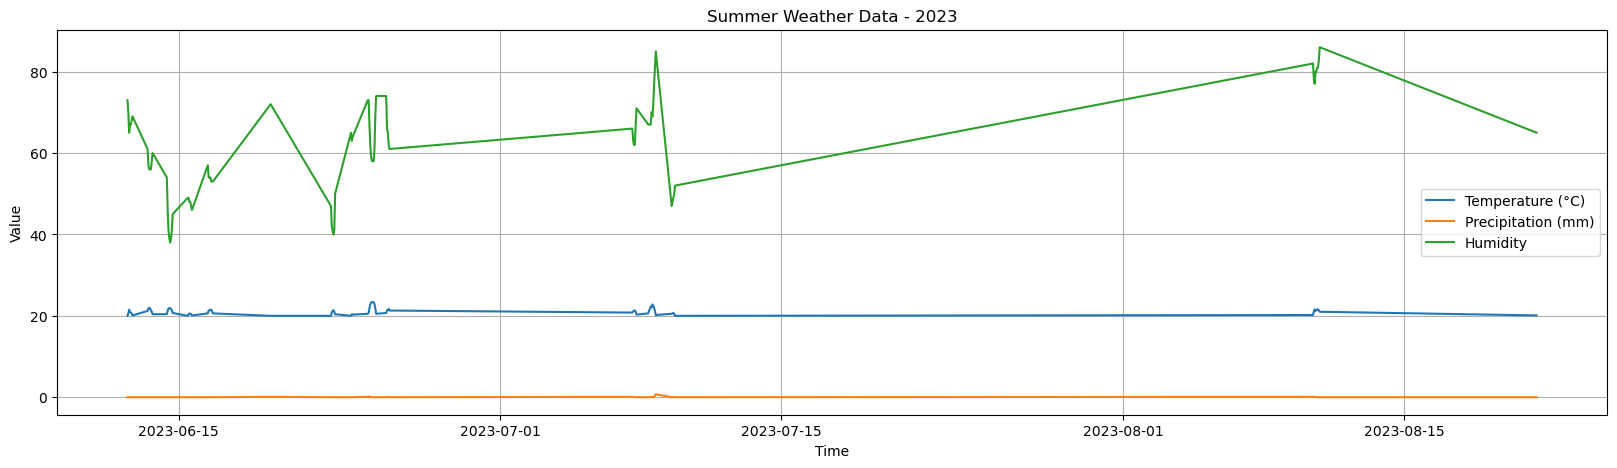

In [1299]:
# Group the data by year
grouped_summer = summer.groupby(summer['time'].dt.year)

# Iterate over each year's summer data
for year, summer_data in grouped_summer:
    # Filter data for the specific year
    summer_year = summer_data[summer_data['time'].dt.year == year]

    # Plot the desired columns
    plt.figure(figsize=(20, 5))
    plt.grid(True)
    plt.plot(summer_year['time'], summer_year['temperature_2m (°C)'], label='Temperature (°C)')
    plt.plot(summer_year['time'], summer_year['precipitation (mm)'], label='Precipitation (mm)')
    plt.plot(summer_year['time'], summer_year['relativehumidity_2m (%)'], label='Humidity')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f"Summer Weather Data - {year}")
    plt.legend()
    plt.show()

# Calculate discomfort index (DI)
Over ten years data, it looks like humidity fractuate a lot it is still difficult to indentify the best period for holidays. Let's take another way. 

According to *[Wikipedia](https://ja.wikipedia.org/wiki/不快指数)*, Discomfort Index can be one of the indicators which is calculated with temperature and humidity. Between **65** and **70** is the best score. I would like to take the score as an indicator.


In [1300]:
# Calculate the discomfort index
summer['score'] = 0.81 * summer['temperature_2m (°C)'] + summer['relativehumidity_2m (%)'] * 0.01 * (0.99 * summer['temperature_2m (°C)'] -14.3) + 46.3

# Get data with DI score between 65 and 70
score_range_data = summer[(summer['score'] >= 65) & (summer['score'] <= 75)]

# Sort data ascending order because colder is better for me
score_range_data = score_range_data.sort_values('score', ascending=True)

# Get the best day for vacation (lowest score)
best_day = score_range_data.iloc[0]
best_day

0
time                         2018-07-06 16:00:00
temperature_2m (°C)                         20.1
relativehumidity_2m (%)                     44.0
dewpoint_2m (°C)                             7.5
apparent_temperature (°C)                   17.4
precipitation (mm)                           0.0
rain (mm)                                    0.0
snowfall (cm)                                0.0
snow_depth (m)                               0.0
windspeed_10m (km/h)                        17.7
windspeed_100m (km/h)                       23.2
winddirection_10m (°)                      253.0
winddirection_100m (°)                     254.0
windgusts_10m (km/h)                        38.2
score                                   65.04456
Name: 2018-07-06 16:00:00, dtype: object

I would like to know the best ten days ever year.

In [1301]:
score_range_data

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),score
time,,,,,,,,,,,,,,,
2018-07-06 16:00:00,2018-07-06 16:00:00,20.1,44.0,7.5,17.4,0.0,0.0,0.0,0.0,17.7,23.2,253.0,254.0,38.2,65.04456
2023-06-22 14:00:00,2023-06-22 14:00:00,20.0,47.0,8.2,20.1,0.0,0.0,0.0,0.0,7.1,9.0,285.0,286.0,20.2,65.08500
2018-07-25 11:00:00,2018-07-25 11:00:00,20.0,48.0,8.8,17.7,0.0,0.0,0.0,0.0,14.3,18.9,227.0,228.0,33.8,65.14000
2015-06-11 16:00:00,2015-06-11 16:00:00,20.0,48.0,8.7,19.4,0.0,0.0,0.0,0.0,4.2,4.3,121.0,138.0,15.5,65.14000
2023-06-15 16:00:00,2023-06-15 16:00:00,20.1,46.0,8.2,17.3,0.0,0.0,0.0,0.0,18.1,24.2,84.0,87.0,38.5,65.15654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-25 13:00:00,2019-07-25 13:00:00,25.4,69.0,19.2,27.3,0.0,0.0,0.0,0.0,16.0,22.2,113.0,119.0,37.1,74.35774
2022-07-18 14:00:00,2022-07-18 14:00:00,27.5,46.0,15.0,28.2,0.0,0.0,0.0,0.0,14.8,19.6,229.0,227.0,35.3,74.52050
2022-07-18 16:00:00,2022-07-18 16:00:00,27.9,43.0,14.0,27.0,0.0,0.0,0.0,0.0,16.3,21.4,235.0,234.0,34.6,74.62703


In [1302]:
fig = px.scatter(score_range_data,
             x = 'time',
             y = 'score',
             color= 'score')

# Add annotations for the best date of each year
for year in score_range_data['time'].dt.year.unique():
    best_day = score_range_data[score_range_data['time'].dt.year == year].iloc[0]
    fig.add_annotation(x=best_day['time'], y=best_day['score'],
                       text=f"Best Date: {best_day['time'].strftime('%m-%d')}",
                       showarrow=False,
                       arrowhead=1,
                       xshift=-10, yshift=-10)

fig.show()

From above figure, lowest scores (most comfortable days) of each year lay in middle of July, early June. 
However, the lowest score could be coincidence. There are lots of days with similar score. Hence, we should look at the frequency of time that fall into the range of DI(65-75).



In [1305]:
# Create 'week' variable which indicates the number of week in a month
score_range_data['day'] = score_range_data['time'].dt.day
score_range_data['week'] = score_range_data['day'].apply(lambda x: math.ceil(x / 7))
score_range_data

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),score,day,week
time,,,,,,,,,,,,,,,,,
2018-07-06 16:00:00,2018-07-06 16:00:00,20.1,44.0,7.5,17.4,0.0,0.0,0.0,0.0,17.7,23.2,253.0,254.0,38.2,65.04456,6,1
2023-06-22 14:00:00,2023-06-22 14:00:00,20.0,47.0,8.2,20.1,0.0,0.0,0.0,0.0,7.1,9.0,285.0,286.0,20.2,65.08500,22,4
2018-07-25 11:00:00,2018-07-25 11:00:00,20.0,48.0,8.8,17.7,0.0,0.0,0.0,0.0,14.3,18.9,227.0,228.0,33.8,65.14000,25,4
2015-06-11 16:00:00,2015-06-11 16:00:00,20.0,48.0,8.7,19.4,0.0,0.0,0.0,0.0,4.2,4.3,121.0,138.0,15.5,65.14000,11,2
2023-06-15 16:00:00,2023-06-15 16:00:00,20.1,46.0,8.2,17.3,0.0,0.0,0.0,0.0,18.1,24.2,84.0,87.0,38.5,65.15654,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-25 13:00:00,2019-07-25 13:00:00,25.4,69.0,19.2,27.3,0.0,0.0,0.0,0.0,16.0,22.2,113.0,119.0,37.1,74.35774,25,4
2022-07-18 14:00:00,2022-07-18 14:00:00,27.5,46.0,15.0,28.2,0.0,0.0,0.0,0.0,14.8,19.6,229.0,227.0,35.3,74.52050,18,3
2022-07-18 16:00:00,2022-07-18 16:00:00,27.9,43.0,14.0,27.0,0.0,0.0,0.0,0.0,16.3,21.4,235.0,234.0,34.6,74.62703,18,3


In [1327]:
# Create a new column for the month as integers
score_range_data['month_int'] = score_range_data['time'].dt.month.astype(int)

fig = px.histogram(
    score_range_data,
    x='week',
    facet_col='month_int',
    category_orders={'month_int': [6, 7, 8], 'week': [1,2,3,4,5]},
    color='week',
    height=500,
    width=1300
)

fig.update_layout(
    title='Frequency of days that scored between 65 and 75 for Discomfort Index, Faceted by Month',
    xaxis=dict(title='Week'),
    yaxis=dict(title='Frequency (hourly)')
)

fig.show()

As a result, 3rd and 4th week of July had more nice time historically, and we can presume that those weeks can be the good candidate for vacation weeks.

## Conclusions

The graphs have shown the volatility of a Edinburgh summer over ten years. Of course this is no guarantee that the weather pattern will repeat itself in future years.